# NYC Central Park Squirrel Project!
## By Rachel Roca
CMSE 890, Fall 2021


## Introduction

   Topological Data Analysis (TDA) provides numerous tools derived from topology to allow us to study the shape of data. While a data point cloud does not have particularly insightful topology, we can use the point cloud as well as some parameter choices, to build a sequence of complexes from which we can extract useful topological information. With a filtered simplicial complex (or nested network or cubical complex as we see later), we can then compute homology. The nth homology describes the nth dimensional holes in the complex, where 0th homology represents the number of connected components, the 1st homology represents the number of loops, and so on with larger dimensions (Munch). For this project, I only focus on $H_0$ and $H_1$.
    
   I utilize TDA to examine the squirrels living in Central Park, as of October 2018. The data was collected by The Squirrel Census, a group that has been censusing urban green areas across the country since 2012. They emphasize storytelling through scientific data collection, and make all of their data publicly accessible  (Squirrel Census). I apply numerous TDA methods to the squirrel data, and explore what types of insight can be drawn from these various tools. Specifically, I investigate persistent homology of the squirrel data by both considering the squirrels individually (using the Rips complex) and as groups spotted in specific regions on a grid (using the adjacency complex and cubical persistence). 
    
   Apart from squirrels being objectively awesome, motivation of this project comes additionally from the vast amount of features provided for each squirrel. My goal is/was to gain experience and practice what will be relevant to the work I plan to do, which would deal with geospatial data. In this way, my project provides exposure to numerous useful skills while analyzing a data set that brings me joy and reminds me of a place I call home.


## Analysis

To begin, we first input the packages we need.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ripser 
from persim import plot_diagrams, bottleneck 
import teaspoon.TDA.Persistence as pP
import teaspoon.MakeData.PointCloud as gPC
import teaspoon.TDA.Draw as Draw
import seaborn as sns #for the heatmaps
import networkx as nx #for visualizing the complexes


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


We then input the data into a pandas dataframe for organization, and display it to get an overall sense of the data. The Squirrel Census data is publically available on the  NYC Open Data website (https://data.cityofnewyork.us/Environment/2018-Central-Park-Squirrel-Census-Squirrel-Data/vfnx-vebw). The Squirrel Census, along with several hundred volunteers systematically spent a few days in mid October combing through Central Park for squirrels. There are 3023 squirrels in the data set, each represented by 31 features. These features range wildly from the standard latitude, longitude, coloring, and age to the more unusual features such as booleans "moans, tail-twitching, foraging". There is also a notes area, where volunteers can leave pertinent and hysterical information about the squirrel's activity. While I would love to do work on the latter features, I focus more on the traditional. Specifically, I examine the squirrels' geospatial location in the park via their coordinates (seen in the X and Y columns), as well as their location on a grid the Squirrel Census applied to Central Park and included in the data (seen in the Hectare column). In addition, I evaluate data based on the squirrels' primary coloring (seen in the Primary Fur Color column).

In [2]:
data = pd.read_csv('2018_Central_Park_Squirrel_Census_-_Squirrel_Data.csv')
data

,X,Y,Unique Squirrel ID,Hectare,Shift,Date,Hectare Squirrel Number,Age,Primary Fur Color,Highlight Fur Color,...,Kuks,Quaas,Moans,Tail flags,Tail twitches,Approaches,Indifferent,Runs from,Other Interactions,Lat/Long
0,-73.956134,40.794082,37F-PM-1014-03,37F,PM,10142018,3,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9561344937861 40.7940823884086)
1,-73.968857,40.783783,21B-AM-1019-04,21B,AM,10192018,4,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9688574691102 40.7837825208444)
2,-73.974281,40.775534,11B-PM-1014-08,11B,PM,10142018,8,NaN,Gray,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.97428114848522 40.775533619083)
3,-73.959641,40.790313,32E-PM-1017-14,32E,PM,10172018,14,Adult,Gray,NaN,...,False,False,False,False,False,False,False,True,NaN,POINT (-73.9596413903948 40.7903128889029)
4,-73.970268,40.776213,13E-AM-1017-05,13E,AM,10172018,5,Adult,Gray,Cinnamon,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9702676472613 40.7762126854894)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3018,-73.963943,40.790868,30B-AM-1007-04,30B,AM,10072018,4,Adult,Gray,NaN,...,False,False,False,False,False,False,False,True,NaN,POINT (-73.9639431360458 40.7908677445466)
3019,-73.970402,40.782560,19A-PM-1013-05,19A,PM,10132018,5,Adult,Gray,White,...,False,False,False,False,False,False,True,False,NaN,POINT (-73.9704015859639 40.7825600069973)
3020,-73.966587,40.783678,22D-PM-1012-07,22D,PM,10122018,7,Adult,Gray,"Black, Cinnamon, White",...,False,False,False,False,False,False,True,False,NaN,POINT (-73.9665871993517 40.7836775064883)
3021,-73.963994,40.789915,29B-PM-1010-02,29B,PM,10102018,2,NaN,Gray,"Cinnamon, White",...,False,False,False,False,False,False,True,False,NaN,POINT (-73.9639941227864 40.7899152327912)


Now we begin to focus in on the columns we are interested in. The variable "sq_location" has two columns, for longitude and latitude, and the rows account for every squirrel. I've decided to analyze squirrel colorings- namely, gray squirrels, black squirrels, and cinnamon squirrels (no, it is not clear to me why they are cinnamon and not just brown). The variables gsq_location, bsq_location, and csq_location represent these squirrel colorings respectively, and contain the same columns. Note that there are 55 values of squirrels with no listed Primary Fur Color, we count them in the general squirrel arrays, but not in the specific fur color arrays. In general going forward, my variables dealing with all squirrels will start with 'sq', variables dealing with only gray squirrels will start with 'gsq', black squirrels 'bsq' and cinnamon squirrels 'csq'.

In [3]:
data['Primary Fur Color'].isnull().values.sum()

55

In [4]:
#creating the specific data frames for all of the squirrels, as well as by primary fur color
sq_location = data[["X","Y"]]
gsq_location = data[data["Primary Fur Color"] == ("Gray")]
gsq_location = gsq_location[["X", "Y"]]

bsq_location = data[data["Primary Fur Color"] == ("Black")]
bsq_location = bsq_location[["X", "Y"]]

csq_location = data[data["Primary Fur Color"] == ("Cinnamon")]
csq_location = csq_location[["X", "Y"]]

#converting to numpy arrays
sq_locationnp = np.array(sq_location)
gsq_locationnp = np.array(gsq_location)
bsq_locationnp = np.array(bsq_location)
csq_locationnp = np.array(csq_location)

Central Park is the largest and most well known park in Manhattan, NY. Spanning from 59th Street to 110th Street south to north, the park has 843 acres. Created in 1858 to address recreational needs of an expanding and busier city, Central Park has remained a fixture of NYC, with 42 million people visiting annually. Within Central Park are numerous landmarks and activities (Park History). The most relevant to this project are the bodies of water, particularly the Lake and the Reservoir. The body of water you see in all the Rom-Coms that take place in NYC where the couple sit on a rowboat and have a moment is the Lake (first picture), not the Reservoir (second picture). The Reservoir stays quiet, with a beautiful walking/running trail that circles it. In addition, the Metropolitan Museum of Art resides inside the park, which will also appear in the analyses.

<img src="Central-Park-Map.jpg" alt="Central-Park-Map"  width="400;"/>

<img src="CPLake.jpg" alt="CPLake"  width="600;"/>

<img src="Jacqueline_Kennedy_Reservoir.jpg" alt="Jacqueline_Kennedy_Reservoir"  width="600;"/>

I decided to center all of the points, since the coordinates values themselves are not meaningful to us. I then plot the 4 scatter plots, for all squirrels, gray squirrels, black squirrels, and cinnamon squirrels. Next to each scatter plot is the respective persistence diagram. I utilized Ripser to build the simplicial complex. Ripser computes the Vietoris Rips complex of the point cloud. The Rips complex is built off of a distance parameter called $\epsilon$ in the definition below, and $d$ in my code at a later cell. We choose a sequence of increasing $\epsilon$s, and take all the points in the point cloud to be vertices. We add higher dimensional simplices if the pairwise distance between points is less than or equal to $\epsilon$ for all vertices in the simplex. As we increase $\epsilon$, we form a filtered simplicial complex, which enables the use of persistent homology. The pth homology group is a quotient group defined as $H_p = Z_p/B_P$, where $Z_p$ is the pth cycle group and $B_p$ is the pth boundary group. The pth homology groups contain classes of cycles that are grouped together if they differ by a boundary. The dimension of $H_p$ is called the pth Betti numbers (Dey and Wang).  We compute the homology of each of the complexes in a fileter simplicial complex, which forms linear transformations between the homology groups. We track the classes as they are born and killed.
 
The persistence diagram plots the birth and death times of 0 and 1 dimensional components, as they appear and disappear within the filtered simplicial complex. Because of this, all points will be in the upper left portion of the graph, and points at infinity represent components that never die, and persist throughout the whole filtered complex after being born.

The code below will take a minute or so to run.

<img src="Screen Shot 2021-11-26 at 8.56.39 PM.png" alt="Screen Shot 2021-11-26 at 8.56.39 PM"  width="600;"/>

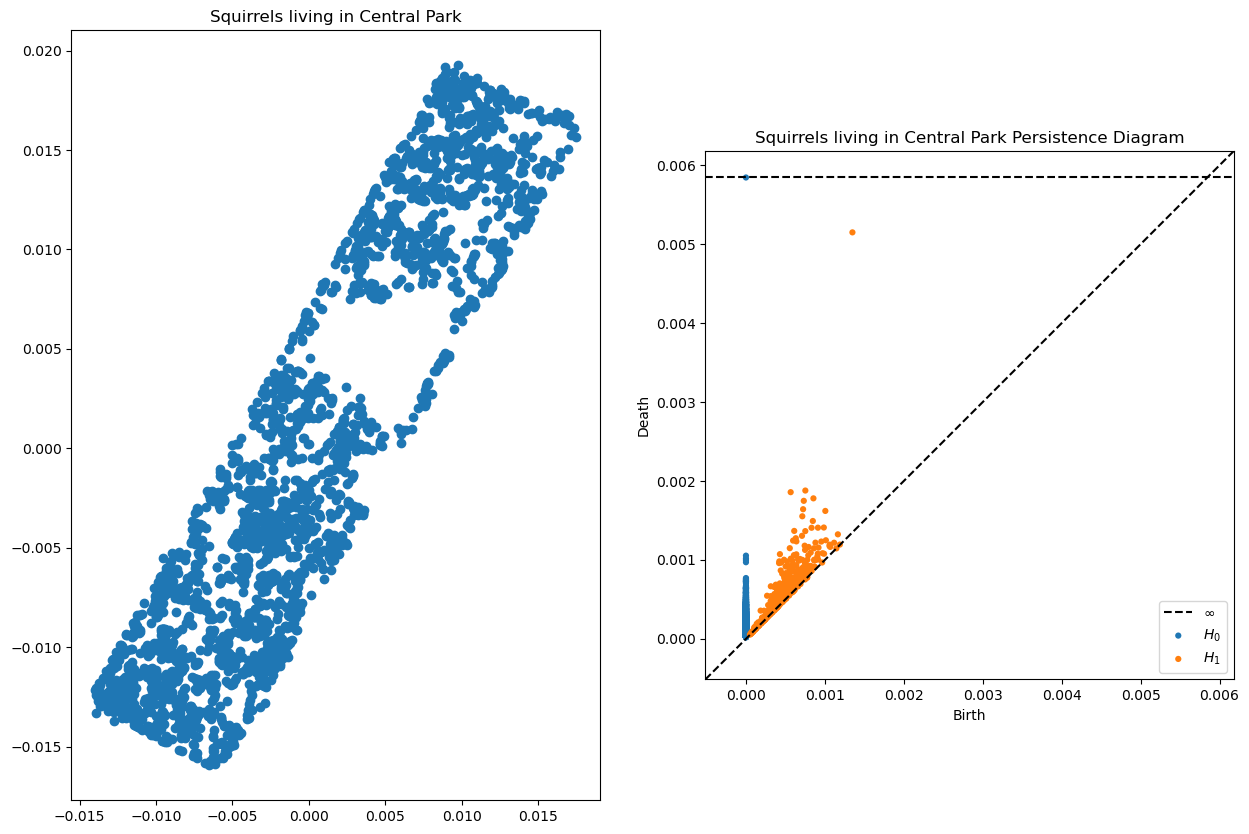

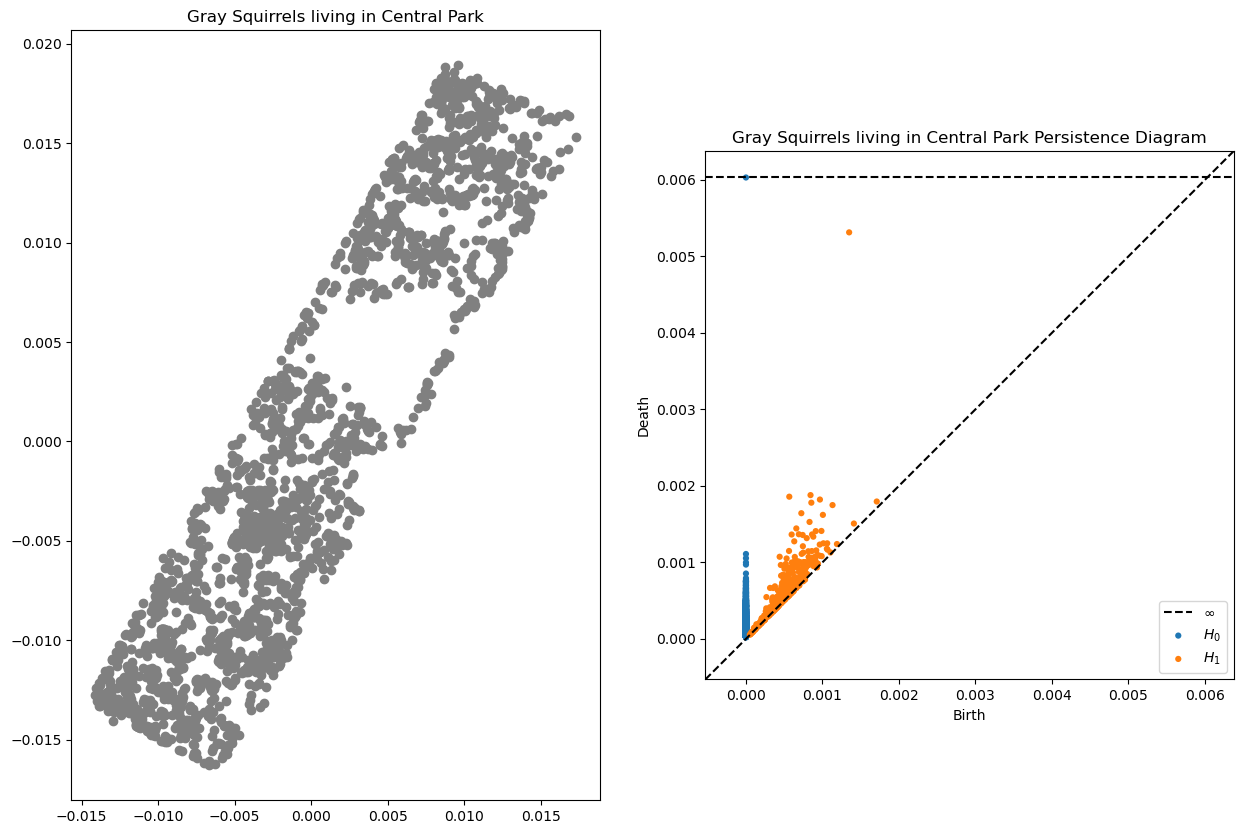

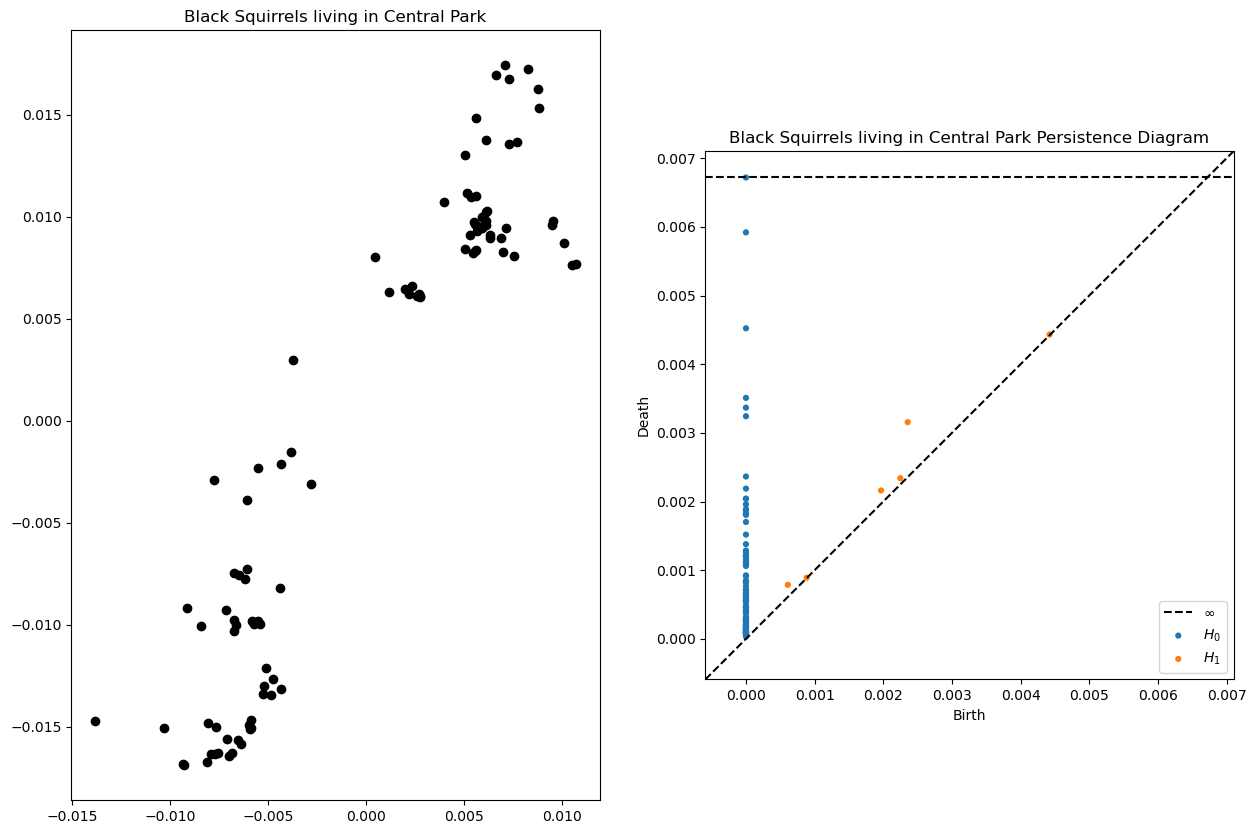

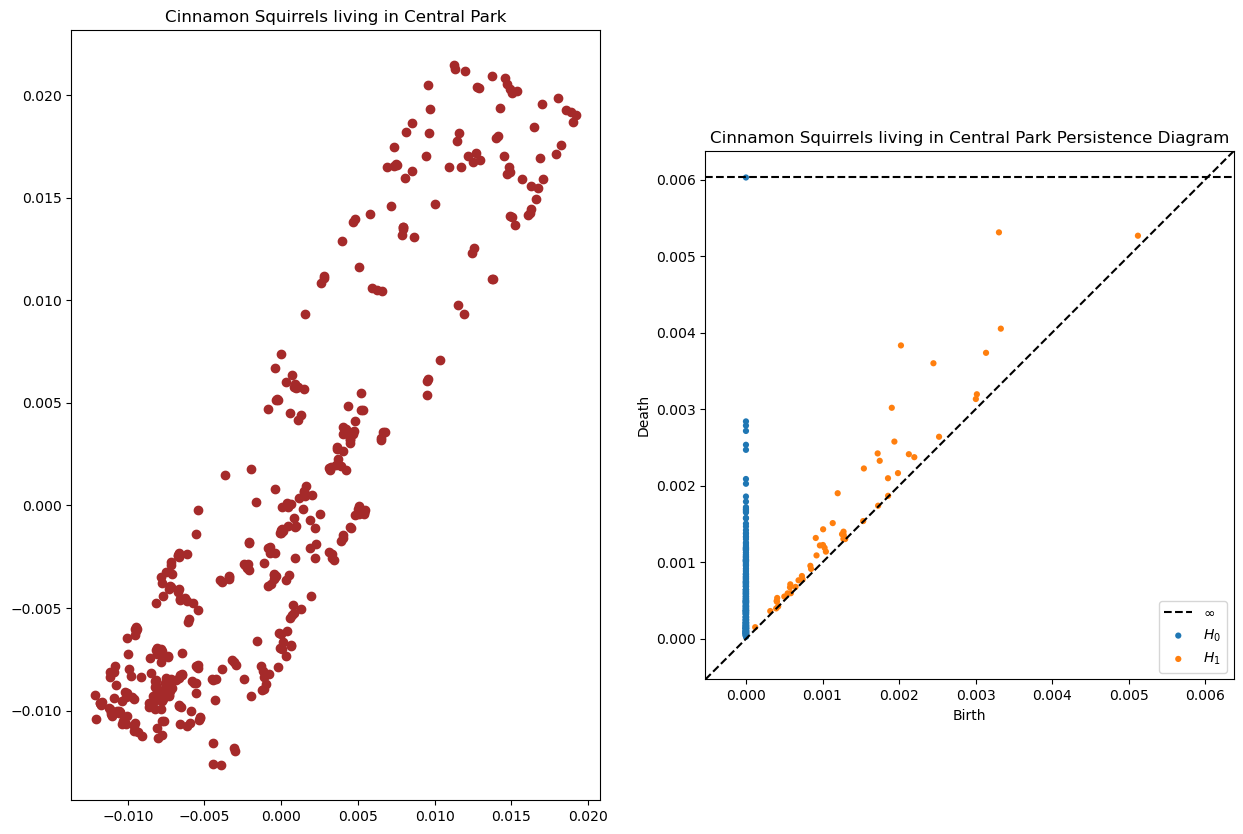

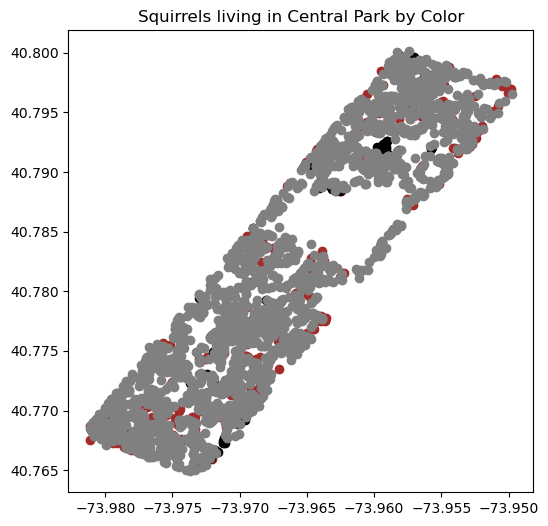

In [5]:
mean = np.mean(sq_locationnp, axis= 0)
sq_locationnp_centered = np.zeros([3023,2])
for i in range(len(sq_locationnp)):
    sq_locationnp_centered[i,0] = (sq_locationnp[i,0]- mean[0])
    sq_locationnp_centered[i,1] = (sq_locationnp[i,1]- mean[1])
#plotting, with a large figure size for better viewing of the individual squirrels
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15, 10))
ax1.scatter(sq_locationnp_centered[:,0],sq_locationnp_centered[:,1])
ax1.set_title("Squirrels living in Central Park")
#plt.savefig("SquirrelsPC.jpg")
SDgms = ripser.ripser(sq_locationnp_centered)['dgms']
plot_diagrams(SDgms)
ax2.set_title("Squirrels living in Central Park Persistence Diagram")
#plt.savefig("SquirrelsPD")
plt.show()


mean = np.mean(gsq_locationnp, axis= 0)
gsq_locationnp_centered = np.zeros([len(gsq_locationnp),2])
for i in range(len(gsq_locationnp)):
    gsq_locationnp_centered[i,0] = (gsq_locationnp[i,0]- mean[0])
    gsq_locationnp_centered[i,1] = (gsq_locationnp[i,1]- mean[1])
#plotting, with a large figure size for better viewing of the individual squirrels
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15, 10))
ax1.scatter(gsq_locationnp_centered[:,0],gsq_locationnp_centered[:,1], c="gray")
ax1.set_title("Gray Squirrels living in Central Park")
#ax1.savefig("GraySquirrelsPC")
GDgms = ripser.ripser(gsq_locationnp_centered)['dgms']
plot_diagrams(GDgms)
ax2.set_title("Gray Squirrels living in Central Park Persistence Diagram")
#ax2.savefig("GraySquirrelsPD")
plt.show()


mean = np.mean(bsq_locationnp, axis= 0)
bsq_locationnp_centered = np.zeros([len(bsq_locationnp),2])
for i in range(len(bsq_locationnp)):
    bsq_locationnp_centered[i,0] = (bsq_locationnp[i,0]- mean[0])
    bsq_locationnp_centered[i,1] = (bsq_locationnp[i,1]- mean[1])
#plotting, with a large figure size for better viewing of the individual squirrels
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15, 10))
ax1.scatter(bsq_locationnp_centered[:,0],bsq_locationnp_centered[:,1], c="black")
ax1.set_title("Black Squirrels living in Central Park")
#lt.savefig("BlackSquirrelsPC.jpg")
BDgms = ripser.ripser(bsq_locationnp_centered)['dgms']
plot_diagrams(BDgms)
ax2.set_title("Black Squirrels living in Central Park Persistence Diagram")
#ax2.savefig("BlackSquirrelsPD")
plt.show()


mean = np.mean(csq_locationnp, axis= 0)
csq_locationnp_centered = np.zeros([len(csq_locationnp),2])
for i in range(len(csq_locationnp)):
    csq_locationnp_centered[i,0] = (csq_locationnp[i,0]- mean[0])
    csq_locationnp_centered[i,1] = (csq_locationnp[i,1]- mean[1])
#plotting, with a large figure size for better viewing of the individual squirrels
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15, 10))
ax1.scatter(csq_locationnp_centered[:,0],csq_locationnp_centered[:,1], c="brown")
ax1.set_title("Cinnamon Squirrels living in Central Park")
#lt.savefig("CinnamonSquirrelsPC.jpg")
CDgms = ripser.ripser(csq_locationnp_centered)['dgms']
plot_diagrams(CDgms)
ax2.set_title("Cinnamon Squirrels living in Central Park Persistence Diagram")
#ax2.savefig("CinnamonSquirrelsPD")
plt.show()


#By color
plt.figure(figsize=(6, 6))
plt.scatter(csq_locationnp[:,0],csq_locationnp[:,1], c="brown")
plt.scatter(bsq_locationnp[:,0],bsq_locationnp[:,1], c="black")
plt.scatter(gsq_locationnp[:,0],gsq_locationnp[:,1], c="gray")
plt.title("Squirrels living in Central Park by Color")
plt.savefig("CSquirrelsPC.jpg")
plt.show()



Now having the persistence diagrams, we can compute the distance between them using the Bottleneck Distance. Below is one of the definitions for the Bottleneck Distance. Basically, out of all possible bijective mappings between the points in the two diagrams, we choose the smallest distance from the set of the largest l-infinity distances between matched points for each given bijection. I use the scikit-tda persim package that has a bottleneck function for the computation.

<img src="Screen Shot 2021-11-27 at 4.35.19 PM.png" alt="Screen Shot 2021-11-27 at 4.35.19 PM"  width="600;"/>

In [6]:
AlltoGray0 = bottleneck(SDgms[0], GDgms[0], matching=False)
AlltoGray1 = bottleneck(SDgms[1], GDgms[1], matching=False)
print(AlltoGray0)
print(AlltoGray1)

AlltoBlack0 = bottleneck(SDgms[0], BDgms[0], matching=False)
AlltoBlack1 = bottleneck(SDgms[1], BDgms[1], matching=False)
print(AlltoBlack0)
print(AlltoBlack1)

AlltoCinnamon0 = bottleneck(SDgms[0], CDgms[0], matching=False)
AlltoCinnamon1 = bottleneck(SDgms[1], CDgms[1], matching=False)
print(AlltoCinnamon0)
print(AlltoCinnamon1)

/Users/rachelroca/opt/anaconda3/lib/python3.8/site-packages/persim/bottleneck.py:56: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/Users/rachelroca/opt/anaconda3/lib/python3.8/site-packages/persim/bottleneck.py:66: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


8.322350913658738e-05
0.00016365200281143188
0.0029599869158118963
0.0019005303038284183
0.00142007227987051
0.0013172547332942486


As we see, the squirrel point clouds and persistence diagrams match with the landscape of Central Park. In looking at the point clouds, it is easiest to view this in the plots featuring all of the squirrels, regardless of fur color. This is because the data is too sparse (for the black squirrels especially) to make out the nature of the park landscape. The largest hole absent of squirrels is around the reservoir. However, we also see smaller holes in areas corresponding to the lake, the Metropolitan Museum of Art, and Harlem Meer. 

This trend is also matched in the persistence diagrams. For the all squirrels dataset, we notice the presence of a persistent 1 dimensional loop structure. Based on the context of the landscape of Central Park, as well as my point cloud, I deduce that this is the reservoir. There is the presence of a lot of noise for the 1 dimensional persistence, but it appears there might be a few points above the diagonal, but close to the noise, that characterize the other features described above. It is worth noting that the persistence diagram of the gray squirrels appears the closest to the persistence diagram of all the squirrels. It is clear to see by visual inspection, and verified by comparing the bottleneck distances. The bottleneck distance from the all squirrel diagram to the gray squirrel diagram is the smallest, while the distance from the all squirrel diagram to the black squirrel diagram is the biggest. In fact, the difference in distances between all squirrels and gray squirrels to all squirrels and black squirrels is over a factor of 10. This occurs since gray squirrels make up the majority of the squirrels living in Central Park, and they appear to be well distributed throughout the park. On the other hand, black squirrels make up the smallest percentage of squirrels by color in Central Park, according to the data. In terms of the 0th dimensional persistence, we see that the black squirrel diagram and cinnamon squirrel diagram have significantly more zero dimensional points away from the diagonal. While all of the connected components are born at 0 (such is the nature of the Rips complex- we start with all the vertices), it takes longer for them to die. This is because the point cloud is much more spread out throughout the park. Further, we need greater distance to connect the points together to kill off the younger components. Likewise, the cinnamon and black squirrel persistence diagrams have some loops that are born much later than the all the squirrels and gray squirrels diagrams. The same reasoning from the connected components apply; since the squirrels are more spread out, we require bigger $\epsilon$ to connect the squirrels in a way to form the loop. There are less 1 dimensional classes present in the cinnamon and black squirrel diagrams, and many aren't particularly persistent. With less squirrels in these datasets, we have less of a representation of the landscape of the park. Looking at the Rips graph below for the cinnamon squirrels, we see that the loops do correspond with bodies of water in the park, but they are born much later. Since the black squirrels are so uncommon, the few loops structures we see appear to be much more independent of the underlying park structure, and more local to the few black squirrel groupings. 


While not used in the computation of the Rips complex and persistence diagrams, below is a function that calculates and displays the 1-skeleton (only vertices and edges) of a Rips complex, given a certain $\epsilon$. The distance function below is used to within the RipsGraph function. It calculates the distance between two, 2d points, and returns 1 if the distance is less than or equal to the $\epsilon$ value (called d here), and 0 if the distance is greater than d.

The RipsGraph (along with the distance function) was taken from my prior work in Homework 2 Question 7. 

In [7]:
def distance(x,y,d):
    dist = np.sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2) #where x=(x[0], x[1]), y=(y[0],y[1])
    if dist <= d:
        return 1
    else: 
        return 0

In [8]:

#From HW 2 Question 7
def RipsGraph(P,d):
    #Inputs is a matrix of the data points (their locations) and a given distance
    #creation of the graph
    G=nx.Graph()
    pos={} #for axes labels
    #to display the nodes
    for i in range(len(P)):
        G.add_node((P[i][0], P[i][1])) #all points will be vertices on the graph,
        #regardless if they are connected to others by edges
        pos[(P[i][0], P[i][1])] = (P[i][0], P[i][1])
    for i in range(len(P)):
        for j in range(i+1,len(P)): #comparing all points to all other points
            dist=distance(P[i],P[j], d)#checks if the distance between the two points are less than/equal to or greater than d
            if dist == 1: 
#if the distance between two points are less than d, add an edge
                G.add_edge((P[i][0], P[i][1]),(P[j][0], P[j][1]))
   #plotting the graph    
    fig, ax = plt.subplots(figsize=(8, 8))
    nx.draw(G, pos=pos, ax=ax, node_size=50)
    ax.set_axis_on()
    plt.axis("on")
    #ax.set_xlim(0, 1)
    #ax.set_ylim(0,1)
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    #plt.savefig("RipsComplex1SkelC"+str(d)+".jpg")
    plt.show()

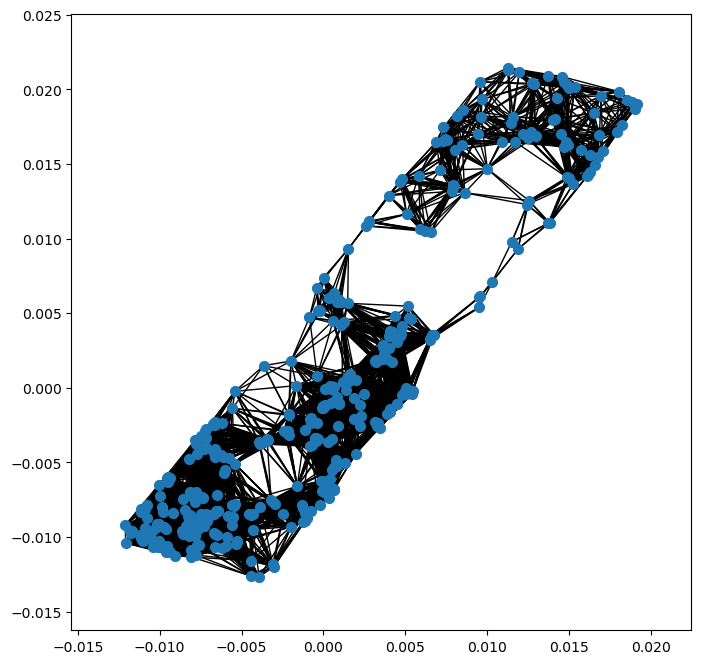

In [9]:
RipsGraph(csq_locationnp_centered,.004)

Below are some samples of the Rips Graph function, all with the cinnamon squirrels. In order to change dataset for displaying the Rips graph, one needs only alter in the first variable: remove the c for all of the squirrels, replace the c with a g for gray squirrels, or replace with a b for black squirrels. The distance is changed with the second input variable.

The distance chosen was motivated by the axis of the persistence diagram of cinnamon squirrels. As we expect from the persistence diagram, by distance .006, all components are dead except for the single connected component that lives forever. Recall that since this is the 1-skeleton, any triangle we see in the graphs would be filled in. Hence at .006, almost everything would be filled in. These graphs also confirm that the persistent 1-dimensional class corresponds to the Reservoir, while the less persistent loops correspond to areas containing bodies of water. I suspect the shape of the Lake greatly attributes to its lack of persistence, since it is made up of narrow tendrils that could be filled in with a smaller distance.

<img src="Screen Shot 2021-12-02 at 11.47.16 AM.png" alt="Screen Shot 2021-12-02 at 11.47.16 AM"  width="700;"/>

Now we pivot from looking at each individual squirrel as its own point in the point cloud, to focusing on each grid section made up of nonnegative amounts of squirrels each. The Hectare grid is created from squares, each with a side length of 100 meters. The North to South side of Central Park is labeled from 1-42, and the East to West side of Central Park is labeled from A-I. This was done to help organize the census, and volunteers and staff were assigned a specific hectare to census (Squirrel Census). The data from the Squirrel Census unfortunately does not provide information as to which direction the labels run from. In fact, in a separate Hectare Grid supplementary page, the ID of Hectare grid regions start at 82. After reaching out to the Squirrel Census folks, the person I had contact with was unsure about the labels. I therefore use my best guess based on the point clouds and landscape of Central Park, but it is to be noted that the heatmaps will be accurate up to a rotation or reflection. Below is an image of the grid. Despite as it appears, each grid entry is a square, which becomes clear when zoomed in enough on the Grid supplementary page.

<img src="Screen Shot 2021-11-26 at 8.09.05 PM.png" alt="Screen Shot 2021-11-26 at 8.09.05 PM"  width="400;"/>


Note that this first heatmap is different than the others coming later. This is a heatmap for the population of squirrels in each grid section, while the followings are percentages based on their colorings. The population squirrel heat map encompasses all squirrels, regardless of color. Some hectares have no squirrels, while others can have up to 32 squirrels.


       A     B     C     D     E     F     G     H     I
42   2.0   2.0  10.0   7.0   6.0   6.0   6.0   7.0   3.0
41   7.0  16.0  11.0  10.0  11.0   2.0   2.0   0.0   3.0
40  10.0  17.0  15.0  14.0   7.0   3.0   8.0   2.0   3.0
39   4.0   7.0   8.0  10.0   7.0   9.0   9.0   7.0   4.0
38  10.0   7.0  21.0  10.0  17.0  12.0  11.0   2.0   6.0
37   3.0  11.0   9.0  10.0  14.0   4.0  15.0  10.0   7.0
36  11.0   9.0  10.0   3.0   5.0  12.0   2.0   4.0  21.0
35  20.0  11.0  14.0  11.0  11.0   4.0   3.0   2.0   3.0
34   8.0   4.0   6.0   6.0   2.0   2.0   2.0   8.0  11.0
33   5.0  18.0   6.0  12.0  22.0   8.0   5.0   2.0  14.0
32  14.0  10.0  19.0  15.0  30.0  15.0   5.0   4.0   9.0
31   9.0   7.0   4.0  11.0  10.0   6.0   1.0   5.0   4.0
30   5.0  21.0   3.0   2.0   4.0   1.0   0.0   4.0   7.0
29   4.0   7.0   8.0   8.0   0.0   0.0   0.0   2.0   1.0
28   6.0   3.0   4.0   8.0   0.0   0.0   0.0   0.0   2.0
27   3.0   2.0   0.0   0.0   0.0   0.0   0.0   0.0   9.0
26   8.0   1.0   0.0   0.0   0.

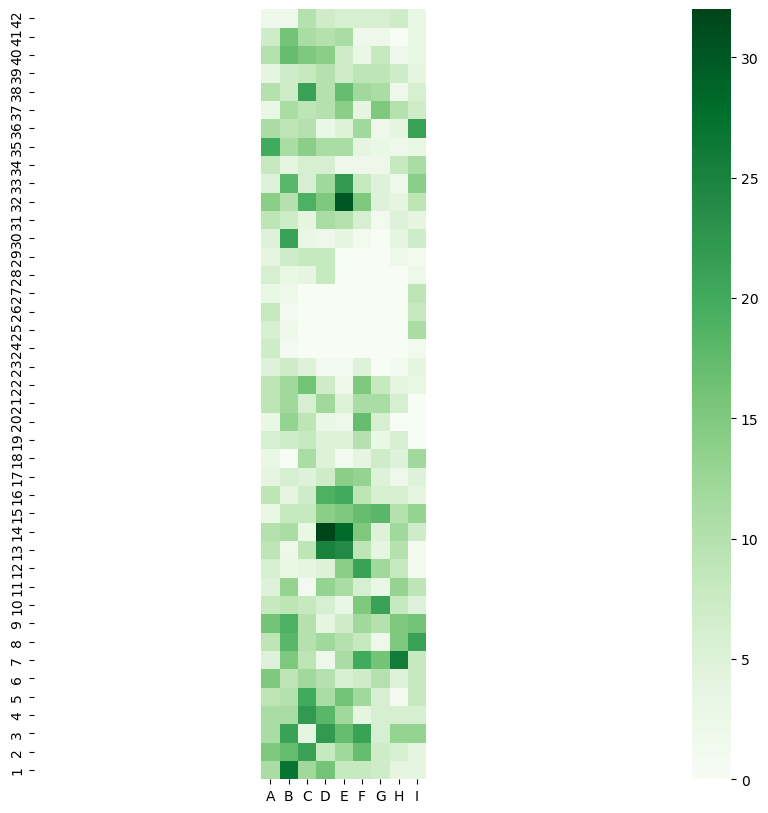

In [10]:
#creating a vector of zeros for each 'column' of the grid, assuming the number labels make up the rows,
# and the letter labels make up the columns
A_pop = np.zeros([42,1])
B_pop = np.zeros([42,1])
C_pop = np.zeros([42,1])
D_pop = np.zeros([42,1])
E_pop = np.zeros([42,1])
F_pop = np.zeros([42,1])
G_pop = np.zeros([42,1])
H_pop = np.zeros([42,1])
I_pop = np.zeros([42,1])
for i in range(42): #for each row, we add the number of squirrels living in a given hectare id to the appropriate letter vector
    j=41-i #I want 42 to be at the north most point of the park, and 1 to be at the south. This was decided based on examination of the data
    if j< 9: #This is done because the data entry in the csv file has an padding 0
        A_pop[i,0]=len(data[data["Hectare"] == ("0" +str(j+1)+"A")])
        B_pop[i,0]=len(data[data["Hectare"] == ("0" +str(j+1)+"B")])
        C_pop[i,0]=len(data[data["Hectare"] == ("0" +str(j+1)+"C")])
        D_pop[i,0]=len(data[data["Hectare"] == ("0" +str(j+1)+"D")])
        E_pop[i,0]=len(data[data["Hectare"] == ("0" +str(j+1)+"E")])
        F_pop[i,0]=len(data[data["Hectare"] == ("0" +str(j+1)+"F")])
        G_pop[i,0]=len(data[data["Hectare"] == ("0" +str(j+1)+"G")])
        H_pop[i,0]=len(data[data["Hectare"] == ("0" +str(j+1)+"H")])
        I_pop[i,0]=len(data[data["Hectare"] == ("0" +str(j+1)+"I")])
    else:
        A_pop[i,0]=len(data[data["Hectare"] == (str(j+1)+"A")])
        B_pop[i,0]=len(data[data["Hectare"] == (str(j+1)+"B")])
        C_pop[i,0]=len(data[data["Hectare"] == (str(j+1)+"C")])
        D_pop[i,0]=len(data[data["Hectare"] == (str(j+1)+"D")])
        E_pop[i,0]=len(data[data["Hectare"] == (str(j+1)+"E")])
        F_pop[i,0]=len(data[data["Hectare"] == (str(j+1)+"F")])
        G_pop[i,0]=len(data[data["Hectare"] == (str(j+1)+"G")])
        H_pop[i,0]=len(data[data["Hectare"] == (str(j+1)+"H")])
        I_pop[i,0]=len(data[data["Hectare"] == (str(j+1)+"I")])

list1= ["A", "B", "C", "D", "E", "F", "G", "H", "I"]
list2 = [ 42-i for i in range(42)]
#placing all data in a dataframe
sqpop_df = pd.DataFrame(0,index=list2, columns= list1)

sqpop_df["A"] =A_pop
sqpop_df["B"] =B_pop
sqpop_df["C"] =C_pop
sqpop_df["D"] =D_pop
sqpop_df["E"] =E_pop
sqpop_df["F"] =F_pop
sqpop_df["G"] =G_pop
sqpop_df["H"] =H_pop
sqpop_df["I"] =I_pop
#Printing the dataframe for dual viewing
print(sqpop_df)
#plotting
fig, ax = plt.subplots(figsize=(10,10)) 
plt.axis('equal')
sns.heatmap(sqpop_df, annot=False, cmap="Greens")
plt.savefig("HeatMapSquirrelPop")

The resulting squirrel population heatmap is not unexpected. Once again, we see less squirrels occupying spaces corresponding to bodies of water and other landscape features. The difference here is that the data is much coarser, and not as fine.

Now we create heatmaps for each of the primary fur colors, where we determine the percentage of squirrels with a given fur color that inhabit that hectare grid space.

             A           B           C           D           E           F  \
42  100.000000   50.000000   80.000000   71.428571   83.333333  100.000000   
41   71.428571   68.750000   72.727273  100.000000   72.727273    0.000000   
40  100.000000  100.000000   93.333333  100.000000   85.714286  100.000000   
39   75.000000   85.714286  100.000000  100.000000   85.714286   88.888889   
38   90.000000   85.714286   95.238095   60.000000   94.117647   91.666667   
37   33.333333   81.818182  100.000000  100.000000   64.285714   75.000000   
36   90.909091   88.888889   90.000000   66.666667  100.000000  100.000000   
35   85.000000   81.818182   78.571429   90.909091  100.000000  100.000000   
34   87.500000   75.000000   66.666667   33.333333   50.000000  100.000000   
33  100.000000   77.777778  100.000000   33.333333   68.181818   87.500000   
32  100.000000   90.000000   94.736842   73.333333   86.666667   93.333333   
31   77.777778  100.000000  100.000000  100.000000  100.000000  

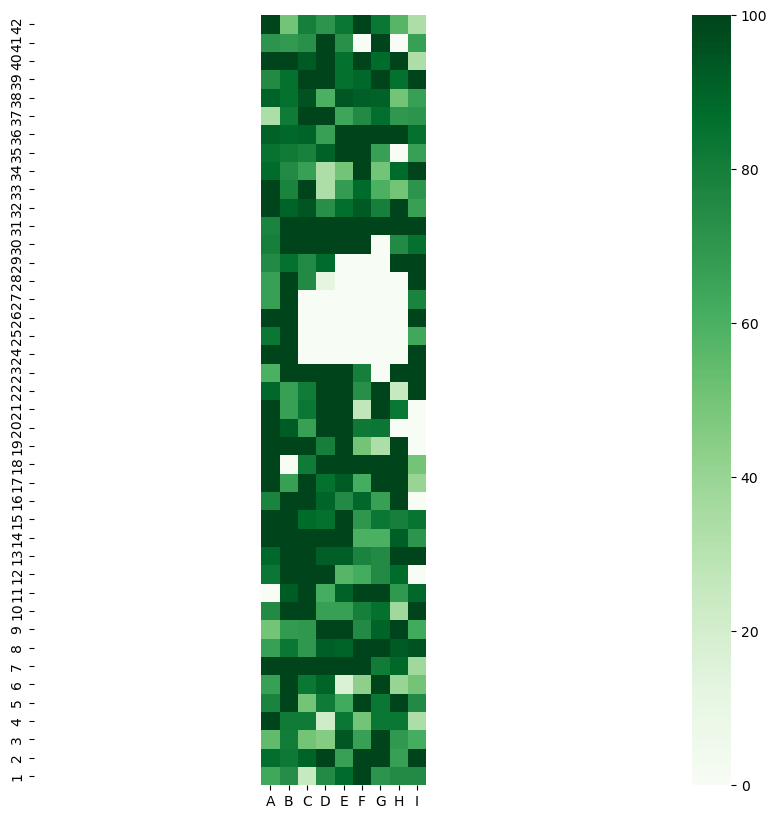

In [11]:
#Gray Squirrel Percentage Heat Map
gsqpop_df = pd.DataFrame(0,index=list2, columns= list1)
#creating a heatmap
for j in list1: #running from A-I
    for i in range(42): #running from 0-41 
        if sqpop_df.at[i+1, j] == 0: #condition to avoid dividing by zero errors
            gsqpop_df.at[i+1, j] == 0
        else: #calculating the percentage
            if i<9:
                gsqpop_df.at[i+1, j] = len(data[(data["Hectare"] == ("0" +str(i+1)+j)) & (data["Primary Fur Color"] == ("Gray"))])
                gsqpop_df.at[i+1, j] = 100 * gsqpop_df.at[i+1, j] / sqpop_df.at[i+1, j] 
            else:
                gsqpop_df.at[i+1, j] = len(data[(data["Hectare"] == (str(i+1)+j)) & (data["Primary Fur Color"] == ("Gray"))])
                gsqpop_df.at[i+1, j] = 100 * gsqpop_df.at[i+1, j] / sqpop_df.at[i+1, j]
print(gsqpop_df)
#plotting
fig, ax = plt.subplots(figsize=(10,10)) 
plt.axis('equal')
sns.heatmap(gsqpop_df, annot=False, cmap="Greens")
plt.savefig("HeatMapGSquirrelPop")

            A          B          C          D          E          F  \
42   0.000000  50.000000   0.000000   0.000000   0.000000   0.000000   
41  28.571429   6.250000   9.090909   0.000000   0.000000   0.000000   
40   0.000000   0.000000   6.666667   0.000000   0.000000   0.000000   
39   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
38  10.000000   0.000000   4.761905  10.000000   0.000000   0.000000   
37   0.000000   9.090909   0.000000   0.000000   0.000000   0.000000   
36   0.000000  11.111111   0.000000   0.000000   0.000000   0.000000   
35   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
34   0.000000   0.000000  33.333333  50.000000  50.000000   0.000000   
33   0.000000   5.555556   0.000000  66.666667  31.818182  12.500000   
32   0.000000   0.000000   0.000000   0.000000  13.333333   6.666667   
31   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
30   0.000000   0.000000   0.000000   0.000000   0.000000   0.00

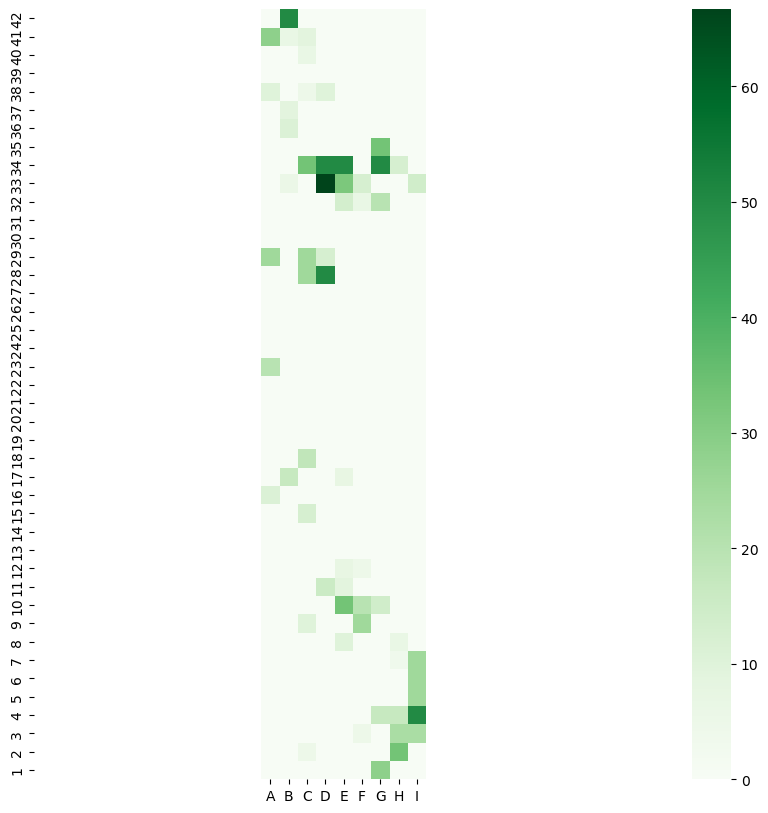

In [12]:
#Black Squirrel Percentage Heat Map
bsqpop_df = pd.DataFrame(0,index=list2, columns= list1)
#creating a heatmap
for j in list1:
    for i in range(42):
        if sqpop_df.at[i+1, j] == 0:
            bsqpop_df.at[i+1, j] == 0
        else:
            if i<9:
                bsqpop_df.at[i+1, j] = len(data[(data["Hectare"] == ("0" +str(i+1)+j)) & (data["Primary Fur Color"] == ("Black"))])
                bsqpop_df.at[i+1, j] = 100 * bsqpop_df.at[i+1, j] / sqpop_df.at[i+1, j]
            else:
                bsqpop_df.at[i+1, j] = len(data[(data["Hectare"] == (str(i+1)+j)) & (data["Primary Fur Color"] == ("Black"))])
                bsqpop_df.at[i+1, j] = 100 * bsqpop_df.at[i+1, j] / sqpop_df.at[i+1, j]
print(bsqpop_df)
#plotting
fig, ax = plt.subplots(figsize=(10,10)) 
plt.axis('equal')
sns.heatmap(bsqpop_df, annot=False, cmap="Greens")
plt.savefig("HeatMapBSquirrelPop")

             A          B          C          D          E          F  \
42    0.000000   0.000000   0.000000  28.571429  16.666667   0.000000   
41    0.000000  18.750000  18.181818   0.000000  27.272727   0.000000   
40    0.000000   0.000000   0.000000   0.000000  14.285714   0.000000   
39   25.000000   0.000000   0.000000   0.000000  14.285714  11.111111   
38    0.000000  14.285714   0.000000  20.000000   5.882353   8.333333   
37   66.666667   9.090909   0.000000   0.000000  28.571429   0.000000   
36    9.090909   0.000000  10.000000  33.333333   0.000000   0.000000   
35   15.000000   9.090909   0.000000   0.000000   0.000000   0.000000   
34   12.500000  25.000000   0.000000  16.666667   0.000000   0.000000   
33    0.000000   5.555556   0.000000   0.000000   0.000000   0.000000   
32    0.000000  10.000000   5.263158  26.666667   0.000000   0.000000   
31   22.222222   0.000000   0.000000   0.000000   0.000000   0.000000   
30   20.000000   0.000000   0.000000   0.000000   0

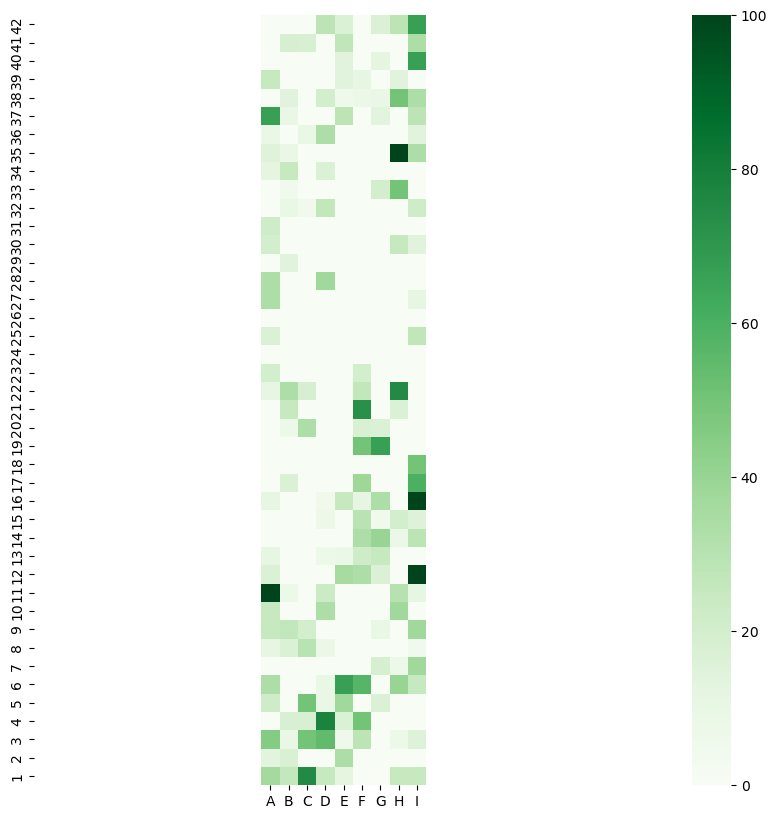

In [13]:
#Cinnamon Squirrel Percentage Heat Map
csqpop_df = pd.DataFrame(0,index=list2, columns= list1)
#getting the data for the heatmap 
for j in list1:
    for i in range(42):
        if sqpop_df.at[i+1, j] == 0:
            csqpop_df.at[i+1, j] == 0
        else:
            if i<9:
                csqpop_df.at[i+1, j] = len(data[(data["Hectare"] == ("0" +str(i+1)+j)) & (data["Primary Fur Color"] == ("Cinnamon"))])
                csqpop_df.at[i+1, j] = 100 * csqpop_df.at[i+1, j] / sqpop_df.at[i+1, j]
            else:
                csqpop_df.at[i+1, j] = len(data[(data["Hectare"] == (str(i+1)+j)) & (data["Primary Fur Color"] == ("Cinnamon"))])
                csqpop_df.at[i+1, j] = 100 * csqpop_df.at[i+1, j] / sqpop_df.at[i+1, j]
print(csqpop_df)
#plotting
fig, ax = plt.subplots(figsize=(10,10)) 
plt.axis('equal')
sns.heatmap(csqpop_df, annot=False, cmap="Greens")
plt.savefig("HeatMapCSquirrelPop")

All of the heatmaps match what we saw in the point clouds and persistence diagrams. Throughout all of the percentage heatmaps, we see 0% in grid entries that would be covered by water. This makes sense, since no squirrels were found in these regions. In the cinnamon and black heatmaps, we see there are areas with high concentrations of these types of squirrels. There is no promising research as to whether cinnamon or black squirrels are more territorial than gray squirrels. Insight on this phenomena would be interesting to look into, and require research in biology and ecology. 

The Adjacency complex is another type of complex from which we can compute homology. The complex was designed by Michelle Feng and Mason Porter, and was motivated as an alternative to the Rips complex for geospatial data. The Adjacency complex does not depend on distance, which is useful when we have irregular regions of various sizes. Feng and Porter applied the complex to voting precincts, for example. In the Adjacency complex, we consider the regions (for us, each grid entry) as nodes in a network. Edges are drawn between nodes if the regions are adjacent to each other. To create nested networks, we utilize a parameter, which in our case will be the percentage value of a given primary fur color. If a hectare in the grid has a percentage value greater than or equal to the specific parameter value chosen, that hectare appears in the network as a node. If two nodes are adjacent, by sharing an edge or corner, we connect them with an edge (Feng and Porter). We start at 100% (such that all squirrels in the given hectare are of a chosen color) and lower this parameter to create the larger networks.

This application does not utilize the geospatial benefits of the Adjacency Complex, since the grid is uniform and composed of squares. That being said, this provided me with an opportunity to get more familiar with the complex and apply it to real world data.

Below is the function I wrote to determine the information of the simplicial complex formed by the adjacency complex given a percentage of some colored fur squirrels living in a specific grid entry. I utilize this function for visualization purposes only. 

In [14]:
#Get our simplicial complex information
#Note that this function has an option for “rook adjacency” and “queen adjacency”.
#“rook adjacency” is when two precincts are adjacent if they share an edge, 
#MF and MAP use "queen adjacency"

def adjacency_complex(df, percent, queen_adjacency=True):
    #it takes in as input a dataframe (coming from the dataframes for the heatmaps above), the percent parameter,
    #and whether we want queen or rook adjacency. The default is queen adjacency.
    #the function returns a list for all the vertices/nodes and edges in the network for a given parameter value
    list1= ["A", "B", "C", "D", "E", "F", "G", "H", "I"]
    vertex_list=[]
    edge_list = []
    for j in list1: #running through the letters identification
        for i in range(42): #running through the number identification
            if df.at[i+1, j] >= percent: #if the hectare has a percentage value >= percent, add to the vertex list
                vertex_list.append([i+1, j])
    for elt in vertex_list: #now we add to the edge list
        #checking vertical neighbor
        if elt[0] != 42:
            if [elt[0]+1, elt[1]] in vertex_list:
                edge_list.append([elt, [elt[0]+1, elt[1]]])
        else:
            if [elt[0]-1, elt[1]] in vertex_list:
                edge_list.append([elt, [elt[0]-1, elt[1]]])
        #checking horizontal neighbor
        for j in range(len(list1)-1):
             if elt[1]==list1[j]:
                if [elt[0], list1[j+1]] in vertex_list:
                    edge_list.append([elt, [elt[0], list1[j+1]]])
    if queen_adjacency: #with queen adjacency we have the possibility of diagonal edges
        for elt in vertex_list:
            if elt[0] != 42 and elt[0] != 0 and elt[1] != list1[0] and elt[1] != list1[8]: #so we don't run off the grid
                for j in range(len(list1)-1):
                     if elt[1]==list1[j]:
                        #upper right diag
                        if [elt[0]+1, list1[j+1]] in vertex_list:
                            edge_list.append([elt, [elt[0]+1, list1[j+1]]])
                        #upper left diag
                        if [elt[0]+1, list1[j-1]] in vertex_list:
                            edge_list.append([elt, [elt[0]+1, list1[j-1]]])
                        #lower right diag
                        if [elt[0]-1, list1[j+1]] in vertex_list:
                            edge_list.append([elt, [elt[0]-1, list1[j+1]]])
                        #lower left diag
                        if [elt[0]-1, list1[j-1]] in vertex_list:
                            edge_list.append([elt, [elt[0]-1, list1[j-1]]])
                    
    return edge_list, vertex_list
        

In [15]:
from operator import itemgetter
def AdjacencyGraph(edge_list, vertex_list):
    #this function takes in the edge_list, vertex_list from the adjacency_complex function and creates the network
    for i in range(len(vertex_list)): #it would appear networkx gets angry without numerical values for everything, so here is the tedious conversion
        if vertex_list[i][1] == 'A':
            vertex_list[i][1] = 0
        if vertex_list[i][1] == 'B':
            vertex_list[i][1] = 1
        if vertex_list[i][1] == 'C':
            vertex_list[i][1] = 2
        if vertex_list[i][1] == 'D':
            vertex_list[i][1] = 3
        if vertex_list[i][1] == 'E':
            vertex_list[i][1] = 4
        if vertex_list[i][1] == 'F':
            vertex_list[i][1] = 5
        if vertex_list[i][1] == 'G':
            vertex_list[i][1] = 6
        if vertex_list[i][1] == 'H':
            vertex_list[i][1] = 7
        if vertex_list[i][1] == 'I':
            vertex_list[i][1] = 8
    
    for i in range(len(edge_list)):
        if edge_list[i][0][1] == 'A': 
            edge_list[i][0][1] = 0 
        if edge_list[i][1][1] == 'A':
            edge_list[i][1][1] = 0
        if edge_list[i][0][1] == 'B':
            edge_list[i][0][1] = 1 
        if edge_list[i][1][1] == 'B':
            edge_list[i][1][1] = 1
        if edge_list[i][0][1] == 'C':
            edge_list[i][0][1] = 2
        if edge_list[i][1][1] == 'C':
            edge_list[i][1][1] = 2
        if edge_list[i][0][1] == 'D':
            edge_list[i][0][1] = 3
        if edge_list[i][1][1] == 'D':
            edge_list[i][1][1] = 3
        if edge_list[i][0][1] == 'E': 
            edge_list[i][0][1] = 4 
        if edge_list[i][1][1] == 'E':
            edge_list[i][1][1] = 4 
        if edge_list[i][0][1] == 'F':
            edge_list[i][0][1] = 5
        if edge_list[i][1][1] == 'F':
            edge_list[i][1][1] = 5
        if edge_list[i][0][1] == 'G':
            edge_list[i][0][1] = 6 
        if edge_list[i][1][1] == 'G':
            edge_list[i][1][1] = 6
        if edge_list[i][0][1] == 'H':
            edge_list[i][0][1] = 7
        if edge_list[i][1][1] == 'H':
            edge_list[i][1][1] = 7
        if edge_list[i][0][1] == 'I':
            edge_list[i][0][1] = 8
        if edge_list[i][1][1] == 'I':
            edge_list[i][1][1] = 8
    #creation of the graph
    G=nx.Graph()
    pos={} #for axes labels
    #to display the nodes
    for i in range(len(vertex_list)):
        G.add_node((vertex_list[i][1], vertex_list[i][0])) #all points will be vertices on the graph,
        #regardless if they are connected to others by edges
        pos[(vertex_list[i][1], vertex_list[i][0])] = (vertex_list[i][1], vertex_list[i][0])
    for i in range(len(edge_list)): #adding the edges
        G.add_edge((edge_list[i][0][1], edge_list[i][0][0]), (edge_list[i][1][1], edge_list[i][1][0]))
    fig, ax = plt.subplots(figsize=(5, 18))
    nx.draw(G, pos=pos, ax=ax, node_size=50)
    ax.set_axis_on()
    plt.axis("on")
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    plt.savefig("=AdjacencyComplex1SkelC0.jpg")
    plt.show()

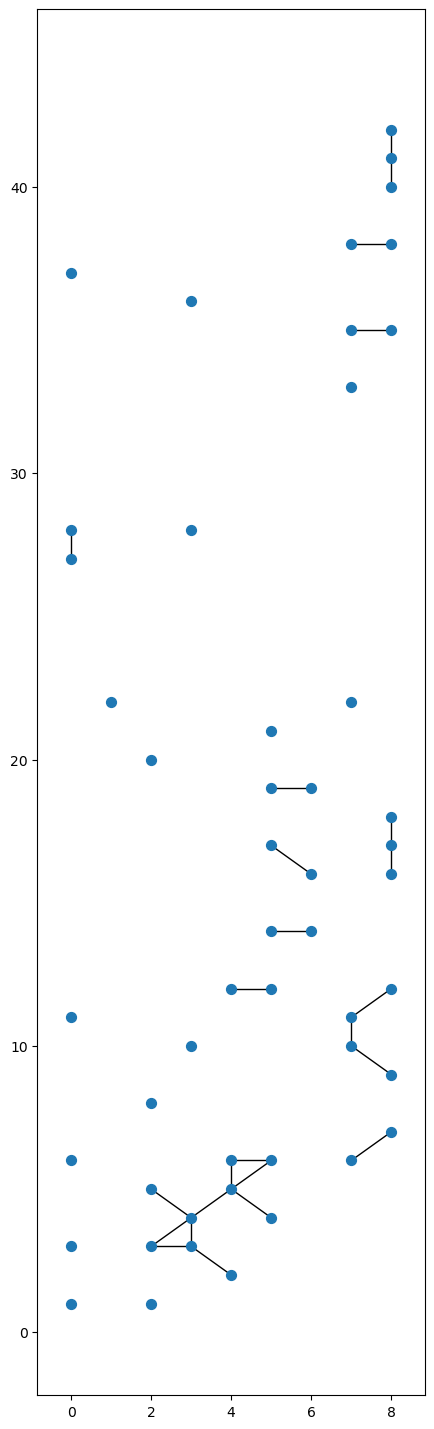

In [16]:
edge_list, vertex_list = adjacency_complex(csqpop_df,30)
AdjacencyGraph(edge_list, vertex_list)

The code provided by Feng and Porter was not in a state that I could make useful for this project within the time constraints. Luckily, instead of creating more functions to compute the persistence from scratch, I was able to leverage cubical complexes. This is because my heatmaps are an image, which is a matrix, where each entry is the percentage value of the given hectare. Therefore, we can consider this to be a cubical complex, and compute the persistence diagrams using a package with cubical persistence. 

An elementary cube $Q$ is a product of elementary intervals, where we call $[l, l+1]$ an elementary nondegenerate interval and $[l]$  an elementary degenerate interval, with $l \in \mathbb{Z}$. The dimension of $Q$ equals the number of nondegenerate components of $Q$. Therefore, the 0-cube is a vertex, the 1-cube is an edge, the 2-cube is a square, and the 3-cube is what we would normally consider as a cube. A set is called cubical if it is made up of a finite union of cubes. The cubical complex from some cubical set $X$ is thus defined as: $K(X) = \{ Q \in K : Q \subset K\}$ (Tymochko et al.). I used the Giotto-TDA package to compute the cubical persistence and plot the resulting persistence diagram. Here is a handy link for the documentation: https://giotto-ai.github.io/gtda-docs/latest/modules/generated/homology/gtda.homology.CubicalPersistence.html
It is worth noting that in the AdjacencyGraph function, we consider each hectare to be a vertex. The cubical code from Giotto-TDA considers each hectare in the grid to be a 2-cube, and two are connected if they share a face (ie an edge or vertex) (Tauzin et al). While we have this difference, fundamentally we are creating complexes and making connections based upon the same parameter values.

In [17]:
from gtda.homology import CubicalPersistence
#Giotto does sublevel persistence, though I want superlevel persistence. Thus I take the negative of all my percentage values.
gsqpop_np=np.array(-gsqpop_df)
bsqpop_np=np.array(bsqpop_df)
csqpop_np=np.array(-csqpop_df)
cubical_persistence = CubicalPersistence(homology_dimensions=(0,1),n_jobs=-1)
gsqpop_cubical = cubical_persistence.fit_transform(gsqpop_np[None, :, :])
bsqpop_cubical = cubical_persistence.fit_transform(bsqpop_np[None, :, :])
csqpop_cubical = cubical_persistence.fit_transform(csqpop_np[None, :, :])
#cubical_persistence.plot(gsqpop_cubical)
cubical_persistence.plot(bsqpop_cubical)
#cubical_persistence.plot(csqpop_cubical)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In pdf form of the Juypter Notebooks, it appears the diagram from the above code does not appear, so below are images of precomputed diagrams. 
<img src="Screen Shot 2021-12-03 at 8.49.55 AM.png" alt="Screen Shot 2021-12-03 at 8.49.55 AM"  width="900;"/>

Giotto-TDA uses sublevel persistence, where the function value parameters start at a smaller value and increase. By the Adjacency complex, we want superlevel persistence, where we start with a high function value parameter and relax the contraint. The axes are negative so that I can compute superlevel persistence and not sublevel persistence, since the original highest function values become the lowest. The negative signs can thus effectively be ignored. It is worth noting that unlike the Rips complex, the Cubical complex is based off of function values, not distances. Thus, the persistence points of the cubical persistence diagrams do not imply anything about the size of the holes. We also note that Giotto-TDA does not plot any points at infinity in the diagram (Tauzin et al).

Feng and Porter utilized the Adjacency Complex in their work to find "political islands" in voting districts. For example, they were looking for a region of blue voting precincts surrounded by a sea of red voting precints in a given district. There case was a bit more binary- if a voting precinct had low blue voting percentage, it almost surely had a large red voting percentage (thanks to our dominant two part system). Here, while there is a possibility that in a hectare, a low percentage of gray squirrels can mean a higher percentage in cinnamon or black squirrels, that hectare can also have no squirrels at all (and thus no percentages of any type of squirrels).
We keep this in mind when looking at the cubical persistence diagrams. 

In the gray cubical persistence diagram, we notice that most of the points appear in the bottom left (above the diagonal of course). This makes sense since gray squirrels are the most numerous and in general have quite high percentages per hectare. Thus many of the 0 dimensional components are born early and die before 60% (except for the 1 connected component that will not die but is not shown here). There are 5 one dimensional points that die at 0%. I gather these can correspond to the bodies of water. The other less persistent loops would correspond to regions with a much lower concentration of gray squirrels compared to around that region. I am unsure if there is any biological or ecological significance to this. With the cinnamon cubical persistence diagram, we see that it takes much longer for the connected components to be born and die, which makes sense, since cinnamon squirrels are not nearly as common as gray squirrels. We also see 5 persistent loops that die at 0%. The image shows three 1d points that die at 0%, but two of these points have multiplicity 2. Like the gray squirrels, this likely represents bodies of water.  Finally, the black squirrels have no H1 points in the cubical persistence diagram. When looking at the heatmap and dataframe with the percentage data, this is not surprising. Many of the values are 0%, and not distributed in such a way that would create a loop. Along this line, the vast majority of the 0 dimensional points die at 0%. With the gray and cinnamon squirrels, we have 'islands' of less concentration of those colored squirrel types. With the black squirrels, we actually have islands of black squirrels in a hectare surrounded by regions with no black squirrels. This is verified by performing sublevel persistence on the black squirrels- we see all of the points but one are representing H1 classes.

## Mapper!

In [29]:
sq_locationnp_centered[:,1]

array([ 0.01322938,  0.00292951, -0.00531939, ...,  0.0028245 ,
        0.00906222, -0.01121256])

In [99]:
import gtda.mapper as map
import sklearn.cluster as cluster


filter_func = map.Projection(columns=[0,1])
#cover = map.OneDimensionalCover(kind='uniform', n_intervals=10, overlap_frac=0.3)
cover = map.CubicalCover(n_intervals=10, overlap_frac=0.3)
clusterer = cluster.DBSCAN()

pipe = map.make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=1,
)

fig = map.plot_static_mapper_graph(pipe, sq_locationnp_centered, color_data=sq_locationnp_centered)
fig.show(config={'scrollZoom': True})
#g = pipe.fit_transform(sq_locationnp_centered)
#color_data=sq_locationnp_centered[:,1]

In [116]:

filter_func = map.Projection(columns=1)
cover = map.OneDimensionalCover(kind='uniform', n_intervals=50, overlap_frac=0.45)
#cover = map.CubicalCover(n_intervals=10, overlap_frac=0.3)
clusterer = cluster.DBSCAN()

pipe = map.make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=1,
)

fig = map.plot_static_mapper_graph(pipe, sq_locationnp_centered, color_data=sq_locationnp_centered)
fig.show(config={'scrollZoom': True})
#g = pipe.fit_transform(sq_locationnp_centered)
#color_data=sq_locationnp_centered[:,1]

In [121]:
data.columns
data_try = data[["Primary Fur Color", 'Running', 'Chasing', 'Climbing', 'Eating',
       'Foraging', 'Kuks', 'Quaas', 'Moans', 'Tail flags',
       'Tail twitches', 'Approaches', 'Indifferent', 'Runs from']]
#drop the rows with NaN values
data_try = data_try.dropna()
#make dummy variables
data_try = pd.get_dummies(data_try, columns=["Primary Fur Color"], drop_first=True)
#replace true/false with 1/0
data_try = data_try.replace(True, 1)
data_try = data_try.replace(False, 0)
data_try

,Running,Chasing,Climbing,Eating,Foraging,Kuks,Quaas,Moans,Tail flags,Tail twitches,Approaches,Indifferent,Runs from,Primary Fur Color_Cinnamon,Primary Fur Color_Gray
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0
6,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3018,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1
3019,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
3020,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1
3021,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1


In [145]:
def l1_norm(X):
    #take the l1 norm of each row
    return np.linalg.norm(X, ord=1, axis=1).reshape(-1, 1)

from sklearn.preprocessing import FunctionTransformer
l1_norm_trans = FunctionTransformer(l1_norm)

filter_func = l1_norm_trans
cover = map.OneDimensionalCover(kind='uniform', n_intervals=20, overlap_frac=0.7)
#cover = map.CubicalCover(n_intervals=10, overlap_frac=0.3)
clusterer = cluster.DBSCAN()

pipe = map.make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=1,
)

fig = map.plot_static_mapper_graph(pipe, data_try)
fig.show(config={'scrollZoom': True})
#g = pipe.fit_transform(sq_locationnp_centered)
#color_data=sq_locationnp_centered[:,1]

## Conclusion

In this project, I both explored squirrels living in Central Park with TDA, and explored topics in TDA with squirrels. Specifically, I focused on three different complexes: the Rips Complex, Adjacency Complex, and Cubical Complex to gain different insights to the squirrels. I additionally added visualizations of both complexes and the squirrels through networks, heatmaps, and point clouds.

We see that gray squirrels are the most common in Central Park, while black squirrels are the least common. Based on all of the findings, regardless of method, we see that the squirrels can provide us with knowledge about the landscape of the park. In particular, areas void of squirrels tend to be bodies of water. This suggests that squirrels are not water critters, and/or the census volunteers did not check the bodies of water for swimming squirrels. Apparently, squirrels have the ability to swim. Regardless, the squirrels allow us to gain information about the landscape of Central Park simultaneously as our knowledge of Central Park gives us insight about squirrels. Overall, this dataset is rich and TDA provides numerous tools for exploring it.


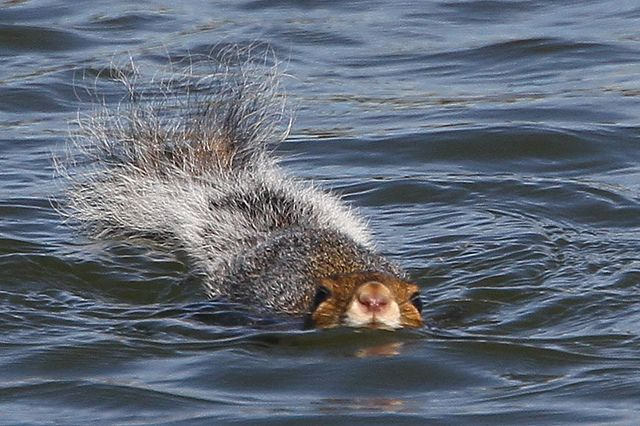

## Acknowledgements

I would like to acknowledge Dr. Liz Munch for her support, guidance, and teaching of the 890 class. I thank the folks at the Squirrel Census for their dedication and meticulous collection of data, as well as quick responses to my emails. A special thanks to Sarah Tymochko for her help with cubical persistence, as well as Umberto Lupo and Wojciech Reise for their help in getting my cubical persistence code working and explaining some finer points of the package. Finally, and most importantly, I would like to thank all of the majestic, amazing squirrels for providing such rich and rewarding data for me to analyze.

## References

Avilés-Rodríguez, Gener José et al. “Topological data analysis for Eye Fundus Image Quality Assessment”. MDPI Jul 2021. Web.

Feng, Michelle, en Mason A. Porter. “Persistent Homology of Geospatial Data: A Case Study with Voting”. arXiv. 2019. Web.

Munch, Elizabeth. “Class notes from CMSE 890”. 2021. Print.

Munch, Elizabeth, en Firas Khasawneh. “Teaspoon: Topological Signal Processing in python”. teaspoon: Topological Signal Processing in Python - teaspoon 0. 1. 0 documentation. Web.

Perea, Jose A., Elizabeth Munch, en Firas A. Khasawneh. “Approximating Continuous Functions on Persistence Diagrams Using Template Functions”. CoRR abs/1902.07190 (2019): n. pag. Web.

“Park history”. Central Park Conservancy. Web.

“Squirrel census”. Squirrel Census 2021. Web.

Tauzin, Guillaume et al. “giotto-tda: A Topological Data Analysis Toolkit for Machine Learning and Data Exploration”. arXiv [cs.LG] 2020. Web.

Tymochko, Sarah et al. “Using persistent homology to quantify a diurnal cycle in Hurricanes”. ScienceDirect Feb 2020. Web.

Wang, Yusu, en Tamal Dey. Computational Topology for Data Analysis. CAMBRIDGE UNIV PRESS, 2022. Print.
